## Imports

In [315]:
import os
import matplotlib.pyplot as plt
import pandas as pd

from obspy import UTCDateTime
from andbro__querrySeismoData import __querrySeismoData

In [316]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

## Configurations

In [354]:
## Configurations

config = {}

config['tbeg'] = UTCDateTime("2023-02-09 00:00")
config['tend'] = UTCDateTime("2023-02-10 00:00")

config['seed'] = "BW.ROMY.10.BJZ"

config['repository'] = "george"

config['outpath'] = f''
config['outfile'] = f''

config['outfigs'] = f''

## Load Rotation Data

In [355]:
st, inv = __querrySeismoData(
                            seed_id=config['seed'],
                            starttime=config['tbeg']-10,
                            endtime=config['tend']+10,
                            repository=config['repository'],
                            path=None,
                            restitute=False,
                            detail=None,
                            fill_value=None,
)


st.trim(config['tbeg'], config['tend'])

st.remove_sensitivity(inv)

st.detrend("demean")

/home/brotzer/anaconda3/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1.2, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


1 Trace(s) in Stream:
BW.ROMY.10.BJZ | 2023-02-08T23:59:59.988399Z - 2023-02-09T23:59:59.988399Z | 20.0 Hz, 1728001 samples

1 Trace(s) in Stream:
BW.ROMY.10.BJZ | 2023-02-08T23:59:59.988399Z - 2023-02-09T23:59:59.988399Z | 20.0 Hz, 1728001 samples

1 Trace(s) in Stream:
BW.ROMY.10.BJZ | 2023-02-08T23:59:59.988399Z - 2023-02-09T23:59:59.988399Z | 20.0 Hz, 1728001 samples

## Load Logfile with MLTI

In [356]:
# mlti = pd.read_csv("/home/brotzer/Downloads/tmp/2023_romy_01_control.log", names=["datetime", "action"])
mlti = pd.read_csv("/import/freenas-ffb-01-data/romy_archive/2023/BW/CROMY/2023_romy_01_control.log", names=["datetime", "action"])

In [357]:
mlti_times = [UTCDateTime(t) for t in mlti['datetime']]
mlti_seconds = [abs(config['tbeg'] - t) for t in mlti_times]

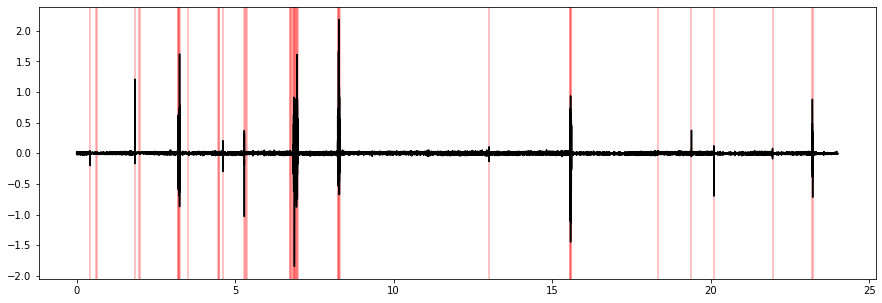

In [358]:
plt.figure(figsize=(15,5))

plt.plot(st[0].times()/3600, st[0].data*1e6, 'k')

for mlti in mlti_seconds:
    plt.axvline(mlti/3600, alpha=0.3, color="r", zorder=0)

plt.show();

In [359]:
st_tmp = st.copy()

traces = []
times = []
time_stamp = []
mlti_bins = []

t1 = config['tbeg'] + 3600

while t1 <= config['tend']:
    time_stamp.append((t1-3600).hour)
    traces.append(st_tmp.copy().trim(t1-3600, t1)[0].data)
    times.append(st_tmp.copy().trim(t1-3600, t1)[0].times())
    t1 += 3600

    mlti_tmp = []
    for mlti in mlti_times:
        if mlti > t1-3600 and mlti < t1:
            mlti_tmp.append(mlti-(t1-3600))
    mlti_bins.append(mlti_tmp)
    
time_stamp.reverse()
# mlti_bins.reverse()

In [360]:
mlti_bins[2]

[685.854611, 746.058947, 806.268384, 866.472654, 926.669804]

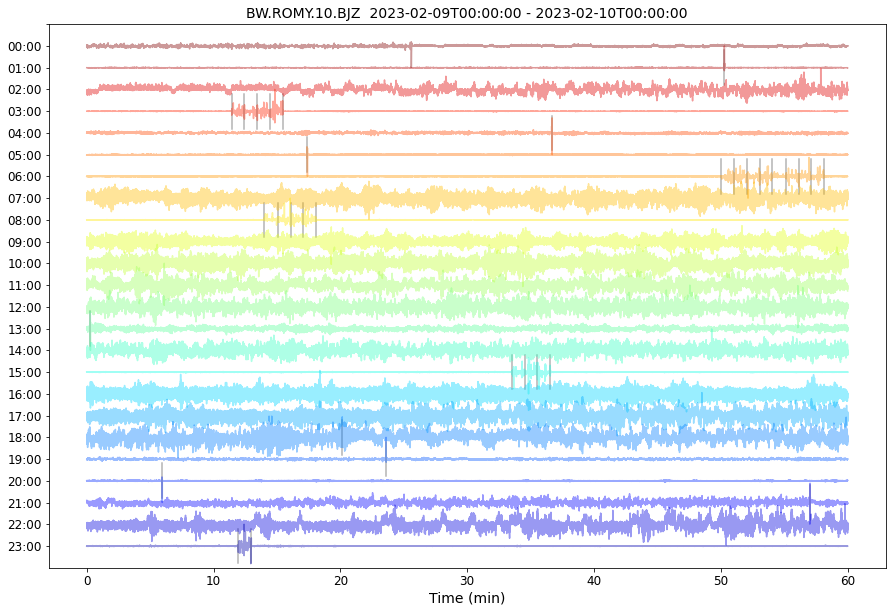

In [361]:
def __makeplot_helicorder(config, traces, times, time_stamps=None, mlti_bins=None):

    from numpy import linspace, shape, nanmax, nanmedian, array

    N = shape(traces)[0]
    
    ## extract colors from colormap
    cols = plt.cm.jet_r(linspace(0, 1, N+1))

    ## ____________________________________________

    fig, ax = plt.subplots(1,1, figsize=(15,10))

    plt.subplots_adjust(wspace=0.15)

    font = 14
    
    timeaxis = linspace(0, 60, len(traces[0]))

    for m, (tr, t_axis) in enumerate(zip(traces, times)):
        
        norm_tr_max = nanmax(abs(tr))
        
        ax.plot(t_axis/60, (tr - nanmedian(tr))/norm_tr_max + N-1-m, color=cols[m], alpha=0.4, zorder=3)

        if mlti_bins:
            for mlti in mlti_bins[m]:

                ax.plot([mlti/60, mlti/60], [-.8+N-2-m, .8+N-2-m], color='k', zorder=1, alpha=0.3)
                
    
    if time_stamps:
        ax.set_yticks(linspace(0, len(time_stamps), len(time_stamps)+1))
        ax.set_yticklabels([str(int(tt)).rjust(2,"0")+":00" for tt in array(time_stamps)])
    else:
        ax.set_yticks(linspace(0,N-1,N))
        labelsy = [str(int(tt)).rjust(2,"0")+":00" for tt in linspace(0,N-1,N)]
        ax.set_yticklabels(labelsy[::-1])
        
    ax.set_ylim(-1, N)

    ax.tick_params(axis='both', labelsize=font-2)

    ax.set_xlabel("Time (min)", fontsize=font)
    
    ax.set_title(f"{config['seed']}  {str(config['tbeg'])[:-8]} - {str(config['tend'])[:-8]}", fontsize=font)
    
    plt.show();
    return fig

__makeplot_helicorder(config, traces, times, time_stamps=time_stamp, mlti_bins=mlti_bins);